In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

In [2]:
# load in data
df_train = pd.read_csv('/home/tomruge/Schreibtisch/Data/Kaggle/playground-series-s4e3/train.csv')
df_test = pd.read_csv('/home/tomruge/Schreibtisch/Data/Kaggle/playground-series-s4e3/test.csv')

# targets are Pastry, Z_Scratch, K_Scatch, Stains, Dirtiness, Bumps, Other_Faults


In [43]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import optuna
import warnings
warnings.filterwarnings("ignore")


class xgboost_model:
    def __init__(self,train,test,target_columns = [], drop_columns = []):
        self.train = train.drop(columns=drop_columns)
        self.test = test.drop(columns=drop_columns)
        self.target = target_columns
        self.drop_columns = drop_columns
    
    def fit(self):
        X_train, X_val, y_train, y_val = train_test_split(self.train.drop(columns = self.target), self.train[self.target], test_size=0.2, random_state=42)
        # to get more stable model, prop
        self.model = XGBClassifier()
        self.model.fit(X_train, y_train)
        print(self.model)
        # prediction for validation data
        self.val_prediction = self.model.predict(X_val)
        # accuracy for validation data
        self.accuracy = roc_auc_score(y_val, self.val_prediction)
        print("Accuracy: %.2f%%" % (self.accuracy * 100.0))
        # i also want to plot the roc curve
        self.plot_roc(y_val)
     
    def predict(self):
        self.prediction = self.model.predict(self.test)        
        return self.prediction
    
    def objective(self, trial):
        X_train, X_val, y_train, y_val = train_test_split(self.train.drop(columns = self.target), self.train[self.target], test_size=0.2, random_state=42)
        params = {'grow_policy': 'depthwise',
                  #'num_class':7,
                       'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1), 
                       'gamma': trial.suggest_uniform('gamma', 0.1, 1), 
                       'subsample': trial.suggest_uniform('subsample', 0.5, 1),
                       'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.3, 1), 
                       'max_depth': trial.suggest_int('max_depth', 5, 30), 
                       'min_child_weight': trial.suggest_int('min_child_weight', 1, 25), 
                       'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-8, 10),
                       'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-8, 10),
                       'booster':'gbtree',
                       'verbosity':0,
                       #'device_type': 'cuda','tree_method': 'gpu_hist'
                        }
        model = XGBClassifier(n_estimators = 500,**params)
        model.fit(X_train, y_train)
        model_prediction = model.predict(X_val)
        # roc aus score
        accuracy = roc_auc_score(y_val, model_prediction)
        return accuracy
    
    def find_params(self):
        study = optuna.create_study(direction='maximize')
        study.optimize(self.objective, n_trials=20)
        print(study.best_params)
        print(study.best_value)
        print(study.best_trial)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)
Accuracy: 70.37%


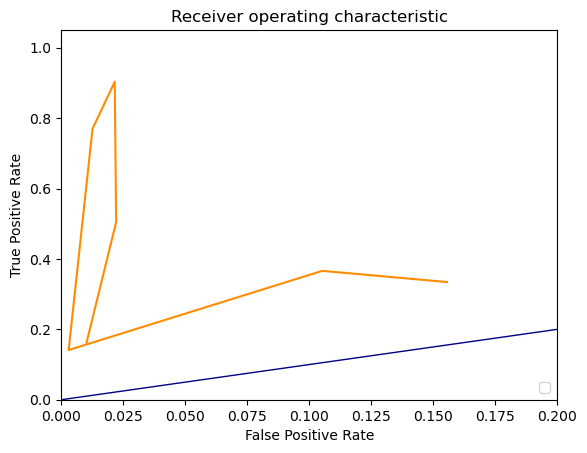

In [44]:
# targets are Pastry, Z_Scratch, K_Scatch, Stains, Dirtiness, Bumps, Other_Faults
target_columns = ['Pastry','Z_Scratch','K_Scatch','Stains','Dirtiness','Bumps','Other_Faults']
drop_columns = ['id']
model = xgboost_model(df_train,df_test,target_columns = target_columns, drop_columns = drop_columns)
model.fit()